In [9]:
import pandas as pd
import numpy as np
import sys

sys.path.append('/Users/benjaminwong/JupyterNotebooks/masters_pfti/notebooks/python/')

import grouping as gr
from clean import PCBCCleaner

In [2]:
df = PCBCCleaner.get_processed_data()

In [3]:
df

,dhid,month,weight,cu,au
0,P08-04W,2021_2,1.000000,0.445853,0.473962
1,P08-04W,2021_4,7.185358,0.445853,0.473962
2,P08-04W,2021_6,90.465466,0.445853,0.473962
3,P08-04W,2021_8,24.556073,0.445853,0.473962
4,P08-04W,2022_1,2247.061308,0.529466,0.554649
...,...,...,...,...,...
13209,P26-12E,2022_9,638.270199,0.632717,0.543535
13210,P26-12E,2022_10,1362.954562,0.711671,0.608383
13211,P26-13E,2022_9,1.000000,0.277313,0.319020
13212,P26-13E,2022_10,1878.426579,0.369132,0.375707


In [2]:
test = pd.read_csv("../data/test.csv")

In [3]:
elements = ['au_ppm', 'cu_pct']
group = gr.Grouping(test)
for element in elements:
    group.add_resource(element, test['depth'], test[element])

In [4]:
group.resources['cu_pct'].heterogeneity

1.1452649388330762

In [5]:
group.resources['au_ppm'].heterogeneity

2.0889270930504003

In [20]:
from abc import ABC, abstractmethod

import pandas as pd
import numpy as np
import os,  sys
import datetime as dt

class Cleaner(ABC):
    @abstractmethod
    def get_processed_data():
        pass
    

class PCBCCleaner(Cleaner):
    @staticmethod
    def get_processed_data():
        data = PCBCCleaner._import_data()
        preprocessed_data = PCBCCleaner._preprocess_data(data)
        
        return preprocessed_data
    
    @staticmethod
    def _import_data():
        FILE_LOC = '../data/ptfi_1/'
        FILE_NAME = 'DP_block_grade estimates_actual tons_dp coordinate.xlsx'

        draw_tons = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Drawn Tons')
        cu_pcbc = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Cu_PCBC')
        au_pcbc = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Au_PCBC')
        dp_coords = pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='DP_Coordinates')

        # data = {}
        # data['draw_tons'] = draw_tons
        return {
            'draw_tons': draw_tons,
            'cu_pcbc': cu_pcbc,
            'au_pcbc': au_pcbc,
            'dp_coords': dp_coords
        }
    
    @staticmethod
    def _preprocess_data(data: dict):
        months = list(data['draw_tons'].columns)
        dhids = list(data['draw_tons'].index)
        
        data['draw_tons'].replace(0, np.nan, inplace=True)
        
        headers = [
            'dhid',
            'month',
            'weight',
            'cu',
            'au'
        ]
        
        data = []
        for dhid in dhids:
            for month in months:
                data.append([
                    dhid,
                    month,
                    data['draw_tons'][month][dhid],
                    data['cu_pcbc'][month][dhid],
                    data['au_pcbc'][month][dhid]
                ])
                
        df = pd.DataFrame(
            data,
            columns=headers
        ).dropna().reset_index(drop=True)
        
        return df

In [21]:
PCBCCleaner.get_processed_data()

TypeError: 'builtin_function_or_method' object is not iterable

In [60]:
def import_data():
    FILE_LOC = '../data/ptfi_1/'
    FILE_NAME = 'DP_block_grade estimates_actual tons_dp coordinate.xlsx'
    
    return {
        'draw_tons': pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Drawn Tons'),
        'cu_pcbc': pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Cu_PCBC'),
        'au_pcbc': pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='Au_PCBC'),
        'dp_coords': pd.read_excel(FILE_LOC + FILE_NAME, sheet_name='DP_Coordinates')
    }
    
def preprocess_data(data: dict):
    names = {
        'Draw Point Name': 'name'
    }

    cols = list(data['draw_tons'].columns)
    for col_name in cols:
        if isinstance(col_name, dt.datetime):
            names[col_name] = f'{col_name.year}_{col_name.month}'
            
    # Draw Tons
    data['draw_tons'] = data['draw_tons'].rename(
        columns = names
    )

    data['draw_tons'] = data['draw_tons'].set_index('name').astype(float)
    
    # CU PCBC
    data['cu_pcbc'] = data['cu_pcbc'].rename(
        columns = names
    )

    data['cu_pcbc'] = data['cu_pcbc'].set_index('name').astype(float)
    
    # AU PCBC
    data['au_pcbc'] = data['au_pcbc'].rename(
        columns = names
    )

    data['au_pcbc'] = data['au_pcbc'].set_index('name').astype(float)
    
    return data
    
def combine_data(pre_d: dict):
    months = list(pre_d['draw_tons'].columns)
    dhids = list(pre_d['draw_tons'].index)
    
    pre_d['draw_tons'].replace(0, np.nan, inplace=True)
    
    headers = [
        'dhid',
        'month',
        'weight',
        'CU',
        'AU'
    ]
    
    data = []

    for dhid in dhids:
        for month in months:
            data.append([
                dhid,
                month,
                pre_d['draw_tons'][month][dhid],
                pre_d['cu_pcbc'][month][dhid],
                pre_d['au_pcbc'][month][dhid]
            ])
    
    return pd.DataFrame(
        data,
        columns=headers
    ).dropna().reset_index(drop=True)

In [61]:
d = import_data()
pre_d = preprocess_data(d)
df = combine_data(pre_d)

In [ ]:
df

,dhid,month,weight,cu,au
0,P08-04W,2021_2,1.000000,0.445853,0.473962
1,P08-04W,2021_4,7.185358,0.445853,0.473962
2,P08-04W,2021_6,90.465466,0.445853,0.473962
3,P08-04W,2021_8,24.556073,0.445853,0.473962
4,P08-04W,2022_1,2247.061308,0.529466,0.554649
...,...,...,...,...,...
13209,P26-12E,2022_9,638.270199,0.632717,0.543535
13210,P26-12E,2022_10,1362.954562,0.711671,0.608383
13211,P26-13E,2022_9,1.000000,0.277313,0.319020
13212,P26-13E,2022_10,1878.426579,0.369132,0.375707


In [12]:
data['draw_tons']

,Draw Point Name,2015-08-01 00:00:00,2015-09-01 00:00:00,2015-10-01 00:00:00,2015-11-01 00:00:00,2015-12-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,...,2022-01-01 00:00:00,2022-02-01 00:00:00,2022-03-01 00:00:00,2022-04-01 00:00:00,2022-05-01 00:00:00,2022-06-01 00:00:00,2022-07-01 00:00:00,2022-08-01 00:00:00,2022-09-01 00:00:00,2022-10-01 00:00:00
0,P04-11W,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P04-12W,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,P04-13W,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,P04-14W,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,P04-15W,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045,P92-07E,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2046,P92-08E,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2047,P92-09E,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2048,P92-10E,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
months = list(data['draw_tons'].columns)
dhids = list(data['draw_tons'].index)

data['draw_tons'].replace(0, np.nan, inplace=True)

headers = [
    'dhid',
    'month',
    'weight',
    'cu',
    'au'
]

data = []
for dhid in dhids:
    for month in months:
        data.append([
            dhid,
            month,
            data['draw_tons'][month][dhid],
            data['cu_pcbc'][month][dhid],
            data['au_pcbc'][month][dhid]
        ])

TypeError: list indices must be integers or slices, not str

In [2]:
def get_processed_data():
    data = _import_data()
    
    assay['Tons_Sampling'] = assay['Tons_Sampling'].astype(float)

    rename_cols = list(assay.columns)[7:-1]
    for col in rename_cols:
        assay = assay.rename(columns={col: col.split('_')[0].upper()})

def _import_data():
    return pd.read_csv("../data/ptfi_1/dmlz_assay.csv")

In [3]:
_import_data()

,SAMPLEID,HOLEID,DATESAMPLED,Oritype,BarcodeNo,Tons_Sampling,SampleWeight,Cu_SampleWeight_Avg,Au_SampleWeight_Avg,Ag_SampleWeight_Avg,Pb_SampleWeight_Avg,Zn_SampleWeight_Avg,F_SampleWeight_Avg,C_SampleWeight_Avg,S_SampleWeight_Avg,Sulfide_SampleWeight_Avg,CNV_SampleWeight_Avg,MPA_SampleWeight_Avg,SamplingType
0,P14-10W_20201002,P14-10W,02-Oct-20,O,U010007,NaN,28.335,1.48,0.72,4.25,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN,Manual
1,P14-11E_20201002,P14-11E,02-Oct-20,O,U010008,NaN,29.650,1.09,1.29,3.99,0.01,0.00,NaN,NaN,NaN,NaN,NaN,NaN,Manual
2,P14-11W_20201002,P14-11W,02-Oct-20,O,U010009,NaN,31.135,2.73,1.61,9.87,0.01,0.03,NaN,NaN,NaN,NaN,NaN,NaN,Manual
3,P14-12W_20201002,P14-12W,02-Oct-20,O,U010011,NaN,30.450,2.55,1.45,6.05,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN,Manual
4,P14-13W_20201002,P14-13W,02-Oct-20,O,U010012,NaN,32.710,3.70,2.39,12.68,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN,Manual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22376,P23-14E_20221030,P23-14E,30-Oct-22,O,U035047,1374.64992,26.414,0.33,0.48,3.68,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN,Manual
22377,P24-02E_20221030,P24-02E,30-Oct-22,O,U035048,638.5512,30.239,1.98,1.29,42.00,0.00,0.08,NaN,NaN,NaN,NaN,NaN,NaN,Manual
22378,P25-10W_20221030,P25-10W,30-Oct-22,O,U035049,910.8840726,26.490,0.51,0.56,3.23,0.01,0.03,NaN,NaN,NaN,NaN,NaN,NaN,Manual
22379,P25-11W_20221030,P25-11W,30-Oct-22,O,U035050,1443.214367,26.995,0.46,0.44,2.36,0.01,0.02,NaN,NaN,NaN,NaN,NaN,NaN,Manual


In [178]:
sys.path.append('/Users/benjaminwong/JupyterNotebooks/masters_pfti/notebooks/python/')

from hetanalysis import HetAnalysis
import plotter
import matplotlib.pyplot as plt

w = [5, 6, 7, 8]
g = [0.5, 0.4, 0.3, 0.7]
group = HetAnalysis('test', w, g)

In [181]:
w = [8, 3, 5, 4, 2, 9, 9, 12]
g = [0.5, 0.4, 0.3, 0.7, 0.5, 0.4, 0.3, 0.7]
group = HetAnalysis('test', w, g)

In [169]:
w = np.random.normal(50, 20, 20)
g = np.random.beta(2, 5, 20) * 2
group = HetAnalysis('test', w, g)

In [183]:
group.get_info()

,weight,grade,cml_weight,weight_pct,cml_weight_pct,yield,cml_yield,cml_grade,recovery,cml_recovery,int_het
0,4,0.7,4,0.076923,0.076923,2.8,2.8,0.700000,0.111111,0.111111,0.001169
1,12,0.7,16,0.230769,0.307692,8.4,11.2,0.700000,0.333333,0.444444,0.010519
2,8,0.5,24,0.153846,0.461538,4.0,15.2,0.633333,0.158730,0.603175,0.000024
3,2,0.5,26,0.038462,0.500000,1.0,16.2,0.623077,0.039683,0.642857,0.000001
4,3,0.4,29,0.057692,0.557692,1.2,17.4,0.600000,0.047619,0.690476,0.000101
5,9,0.4,38,0.173077,0.730769,3.6,21.0,0.552632,0.142857,0.833333,0.000913
6,5,0.3,43,0.096154,0.826923,1.5,22.5,0.523256,0.059524,0.892857,0.001342
7,9,0.3,52,0.173077,1.000000,2.7,25.2,0.484615,0.107143,1.000000,0.004347


In [182]:
group.get_heterogeneity()

0.14733861986609237

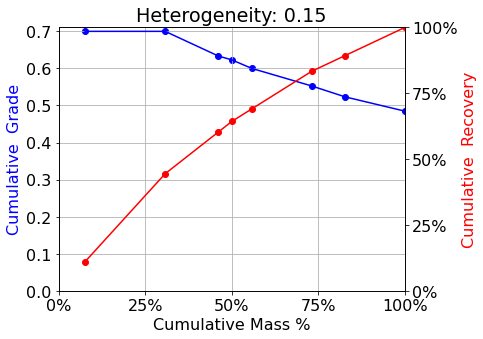

In [184]:
fig = plt.figure()
fig.set_size_inches(7, 5)

plt.rcParams.update(
    {
        'font.size': 16
    }
)

ax = fig.add_subplot()

het = group.get_heterogeneity()
info = group.get_info()

if len(info) > 0:
    ax.set_title(f'Heterogeneity: {het:.2f}')
    ax_sec = ax.twinx()
    
    plotter.plot_g_r(ax, ax_sec, info, ls='-')
    plotter.scatter_g_r(ax, ax_sec, info)
    
    plotter.set_g_r_labels(ax, ax_sec, "")
    ax.grid()

    fig.tight_layout()
    fig.savefig('sample.png', format='png', dpi=100)